
## Game N Gen

* python 3.10 


In [1]:

## !pip install torchvision

# Install the 'einops' library for easy manipulation of tensors
## !pip install einops

# Install the 'lpips' library for computing perceptual similarity between images
## !pip install lpips
## !pip install tqdm


In [2]:

import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from einops import rearrange
import math


In [3]:

torch.cuda.is_available()


True

In [4]:

import condDiffusionTK as condDiff_TK
import UnetTransformer as UnetTransformer


In [5]:

condDiff_obj    = condDiff_TK.condDiffusion()


In [7]:

condDiff_obj.load_MIST()


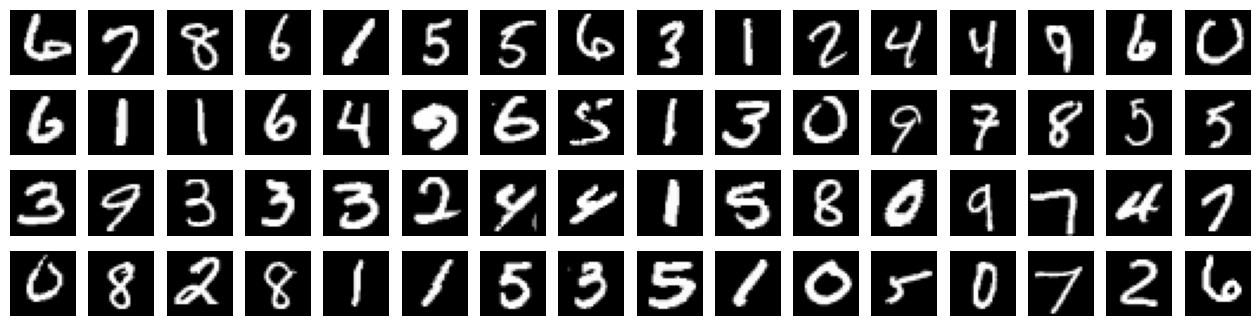

In [8]:

condDiff_obj.my_view_sample_MNIST()


In [11]:

condDiff_obj.init_marginal_prob_diff_coeff()


In [12]:

def loss_fn_cond(model, x, y, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models with conditional information.

    Parameters:
    - model: A PyTorch model instance that represents a time-dependent score-based model.
    - x: A mini-batch of training data.
    - y: Conditional information (target tensor).
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - eps: A tolerance value for numerical stability.

    Returns:
    - loss: The calculated loss.
    """
    
    # Sample time uniformly in the range [eps, 1-eps]
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    # Generate random noise with the same shape as the input
    z = torch.randn_like(x)
    # Compute the standard deviation of the perturbation kernel at the sampled time
    std = marginal_prob_std(random_t)
    # Perturb the input data with the generated noise and scaled by the standard deviation
    perturbed_x = x + z * std[:, None, None, None]
    # Get the model's score for the perturbed input, considering conditional information
    score = model(perturbed_x, random_t, y=y)
    # Calculate the loss using the score and perturbation
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3)))
    return loss


In [13]:

continue_training = False ## continue training or initialize a new model

if not continue_training:

    # Initialize a new UNet with Transformer model
    score_model = torch.nn.DataParallel(UnetTransformer.UNet_Tranformer(marginal_prob_std=condDiff_obj.marginal_prob_std_fn))
    score_model = score_model.to(condDiff_obj.device)


batch_size =  1024 #{'type':'integer'}


dataset     = MNIST('.', train=True, transform=condDiff_obj.transform, download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)


optimizer = Adam(score_model.parameters(), lr=condDiff_obj.lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))

# Use tqdm to display a progress bar over epochs
tqdm_epoch = trange(condDiff_obj.n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0

    for x, y in tqdm(data_loader):
        x = x.to(condDiff_obj.device)

        loss = loss_fn_cond(score_model, x, y, condDiff_obj.marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    # Adjust learning rate using the scheduler
    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]

    print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))

    torch.save(score_model.state_dict(), 'ckpt_transformer.pth')


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

/home/maquina1/Desktop/CLXgameNgen/condDiffusionTK.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=self.device)


0 Average Loss: 977.716491 lr 9.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

1 Average Loss: 289.195320 lr 9.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

2 Average Loss: 193.360912 lr 9.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

3 Average Loss: 143.938148 lr 9.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

4 Average Loss: 117.565764 lr 9.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

5 Average Loss: 101.682277 lr 8.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

6 Average Loss: 91.622087 lr 8.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

7 Average Loss: 84.121256 lr 8.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

8 Average Loss: 79.006537 lr 8.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

9 Average Loss: 73.727037 lr 8.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

10 Average Loss: 70.674655 lr 8.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

11 Average Loss: 67.696323 lr 7.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

12 Average Loss: 64.966318 lr 7.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

13 Average Loss: 62.485638 lr 7.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

14 Average Loss: 60.891848 lr 7.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

15 Average Loss: 59.357517 lr 7.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

16 Average Loss: 57.975631 lr 7.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

17 Average Loss: 57.221004 lr 7.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

18 Average Loss: 55.862836 lr 6.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

19 Average Loss: 54.452871 lr 6.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

20 Average Loss: 53.675248 lr 6.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

21 Average Loss: 52.294056 lr 6.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

22 Average Loss: 52.258777 lr 6.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

23 Average Loss: 51.058668 lr 6.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

24 Average Loss: 49.942727 lr 6.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

25 Average Loss: 49.549896 lr 5.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

26 Average Loss: 48.583036 lr 5.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

27 Average Loss: 48.083689 lr 5.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

28 Average Loss: 47.049481 lr 5.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

29 Average Loss: 46.593085 lr 5.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

30 Average Loss: 46.187898 lr 5.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

31 Average Loss: 45.172893 lr 5.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

32 Average Loss: 45.021154 lr 5.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

33 Average Loss: 44.387214 lr 5.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

34 Average Loss: 43.998320 lr 4.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

35 Average Loss: 43.642097 lr 4.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

36 Average Loss: 42.689699 lr 4.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

37 Average Loss: 42.596034 lr 4.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

38 Average Loss: 42.114690 lr 4.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

39 Average Loss: 41.976515 lr 4.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

40 Average Loss: 42.066486 lr 4.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

41 Average Loss: 41.189277 lr 4.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

42 Average Loss: 40.933142 lr 4.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

43 Average Loss: 40.757872 lr 4.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

44 Average Loss: 40.573191 lr 4.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

45 Average Loss: 39.999884 lr 3.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

46 Average Loss: 39.829532 lr 3.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

47 Average Loss: 39.586352 lr 3.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

48 Average Loss: 39.373251 lr 3.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

49 Average Loss: 39.091666 lr 3.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

50 Average Loss: 39.107445 lr 3.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

51 Average Loss: 38.728205 lr 3.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

52 Average Loss: 38.359764 lr 3.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

53 Average Loss: 38.294659 lr 3.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

54 Average Loss: 38.207250 lr 3.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

55 Average Loss: 37.822992 lr 3.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

56 Average Loss: 37.677524 lr 3.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

57 Average Loss: 37.905375 lr 3.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

58 Average Loss: 36.930786 lr 3.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

59 Average Loss: 37.183128 lr 3.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

60 Average Loss: 37.004881 lr 2.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

61 Average Loss: 37.070290 lr 2.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

62 Average Loss: 36.381972 lr 2.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

63 Average Loss: 36.288888 lr 2.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

64 Average Loss: 36.746027 lr 2.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

65 Average Loss: 36.622203 lr 2.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

66 Average Loss: 36.205735 lr 2.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

67 Average Loss: 36.093768 lr 2.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

68 Average Loss: 35.904906 lr 2.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

69 Average Loss: 35.826987 lr 2.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

70 Average Loss: 35.733798 lr 2.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

71 Average Loss: 35.443610 lr 2.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

72 Average Loss: 35.464085 lr 2.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

73 Average Loss: 35.576991 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

74 Average Loss: 35.499047 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

75 Average Loss: 35.446302 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

76 Average Loss: 35.091912 lr 2.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

77 Average Loss: 34.690128 lr 2.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

78 Average Loss: 34.676524 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

79 Average Loss: 34.598035 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

80 Average Loss: 34.536854 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

81 Average Loss: 34.811746 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

82 Average Loss: 34.724558 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

83 Average Loss: 34.134111 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

84 Average Loss: 34.293265 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

85 Average Loss: 34.161736 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

86 Average Loss: 34.272068 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

87 Average Loss: 33.976365 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

88 Average Loss: 34.016153 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

89 Average Loss: 34.104144 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

90 Average Loss: 33.853146 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

91 Average Loss: 33.999253 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

92 Average Loss: 33.451584 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

93 Average Loss: 33.639510 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

94 Average Loss: 33.655414 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

95 Average Loss: 33.460225 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

96 Average Loss: 33.411197 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

97 Average Loss: 33.400784 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

98 Average Loss: 33.185269 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

99 Average Loss: 33.010984 lr 2.0e-04


  0%|          | 0/250 [00:00<?, ?it/s]

/home/maquina1/Desktop/CLXgameNgen/condDiffusionTK.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=self.device)


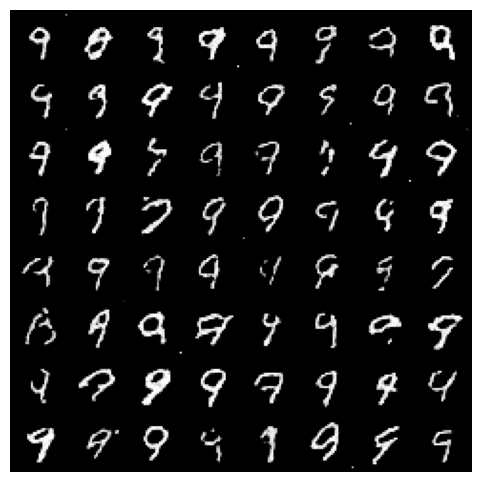

In [14]:

ckpt = torch.load('ckpt_transformer.pth', map_location=condDiff_obj.device)
score_model.load_state_dict(ckpt)


########### Specify the digit for which to generate samples
###########
digit = 9
###########
###########


sample_batch_size = 64
# Set the number of steps for the Euler-Maruyama sampler
num_steps = 250
# Choose the sampler type (Euler-Maruyama, pc_sampler, ode_sampler)
sampler = condDiff_obj.Euler_Maruyama_sampler # ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
# score_model.eval()

## Generate samples using the specified sampler.
samples = sampler(score_model,
                  condDiff_obj.marginal_prob_std_fn,
                  condDiff_obj.diffusion_coeff_fn,
                  sample_batch_size,
                  num_steps=num_steps,
                  device=condDiff_obj.device,
                  y=digit*torch.ones(sample_batch_size, dtype=torch.long)
)

############### Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
# Create a grid of samples for visualization
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))


plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()


In [29]:

'''

import torch
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

def show_images_in_same_spot(images, delay=0.3):
    for img in images:
        clear_output(wait=True)
        plt.imshow(img, cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        display(plt.gcf())
        time.sleep(delay)

images = [torch.rand(28, 28).numpy() for _ in range(30)]

show_images_in_same_spot(images, delay=0.1)

'''


"\n\nimport torch\nimport matplotlib.pyplot as plt\nfrom IPython.display import display, clear_output\nimport time\n\ndef show_images_in_same_spot(images, delay=0.3):\n    for img in images:\n        clear_output(wait=True)\n        plt.imshow(img, cmap='gray', vmin=0, vmax=1)\n        plt.axis('off')\n        display(plt.gcf())\n        time.sleep(delay)\n\nimages = [torch.rand(28, 28).numpy() for _ in range(30)]\n\nshow_images_in_same_spot(images, delay=0.1)\n\n"

In [15]:

'''
combined_cond = torch.cat([prev_img_latent, controller], dim=1)

trajectory = [
    (controller=[1,0,...], image=img1),
    (controller=[0,1,...], image=img2),
    ...
]

'''


'\ncombined_cond = torch.cat([prev_img_latent, controller], dim=1)\n\ntrajectory = [\n    (controller=[1,0,...], image=img1),\n    (controller=[0,1,...], image=img2),\n    ...\n]\n\n'

In [27]:

from IPython.display import HTML

def animate_images_html(images, interval=100):
    fig, ax = plt.subplots()
    im = ax.imshow(images[0], cmap='gray', vmin=0, vmax=1)
    ax.axis('off')

    def update(i):
        im.set_array(images[i])
        return [im]

    ani = animation.FuncAnimation(
        fig, update, frames=len(images),
        interval=interval, blit=True, repeat=False
    )
    return HTML(ani.to_jshtml())  # Return HTML animation



In [28]:

images = [torch.rand(28, 28).numpy() for _ in range(30)]
animate_images_html(images, interval=100)



<IPython.core.display.Javascript object>

In [46]:

samples1 = sampler(score_model,
                  condDiff_obj.marginal_prob_std_fn,
                  condDiff_obj.diffusion_coeff_fn,
                  1,          ## batch size
                  num_steps=num_steps,
                  device=condDiff_obj.device,
                  y=digit*torch.ones(sample_batch_size, dtype=torch.long)
)


/home/maquina1/Desktop/CLXgameNgen/condDiffusionTK.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=self.device)


  0%|          | 0/250 [00:00<?, ?it/s]

/home/maquina1/Desktop/CLXgameNgen/condDiffusionTK.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=self.device)


In [47]:

samples1[0].shape


torch.Size([1, 28, 28])

In [48]:

type(samples1[0])


torch.Tensor

In [49]:

from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation

def animate_images_with_labels_html(images, labels, interval=100):
    fig, ax = plt.subplots()
    im = ax.imshow(images[0], cmap='gray', vmin=0, vmax=1)
    title = ax.set_title(f"Label: {labels[0]}", fontsize=14)
    ax.axis('off')

    def update(i):
        im.set_array(images[i])
        title.set_text(f"Label: {labels[i]}")
        return [im, title]

    ani = animation.FuncAnimation(
        fig, update, frames=len(images),
        interval=interval, blit=True, repeat=False
    )
    return HTML(ani.to_jshtml())



In [50]:

import random

images = []
labels = []

for i in range(30):
    digit = random.randint(0, 9)
    samples1 = sampler(score_model,
                  condDiff_obj.marginal_prob_std_fn,
                  condDiff_obj.diffusion_coeff_fn,
                  1,          ## batch size
                  num_steps=num_steps,
                  device=condDiff_obj.device,
                  y=digit*torch.ones(sample_batch_size, dtype=torch.long)
    )
    res = samples1[0].squeeze(0)
    res = res.cpu().numpy() 
    images.append( res ) 
    labels.append( digit )



  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [52]:

## animate_images_html(images, labels, interval=100)

animate_images_with_labels_html(images, labels, interval=1000)


<IPython.core.display.Javascript object>